# Time Series Analysis for Corn Future Price using ARIMA

In [5]:
# Project 3      
#importing libraries 
import pandas as pd
import numpy as np
import seaborn as sns 
import datetime as dt
import plotly.express as px
import os
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import hvplot.pandas
from pandas_datareader import data as wb
from statsmodels.tsa.arima_model import ARIMA

In [6]:
# Read in corn actual price and sort by date
corn_act_prices = pd.read_csv(Path("../Resources/corn-prices-historical-chart-data.csv"), index_col="date", infer_datetime_format=True, parse_dates=True).sort_index()
# Drop corn actual price data prior to 2000
corn_act_prices = corn_act_prices.loc['2000-1-1':]
# Rename the columns
corn_act_prices.columns.values[0] = "Corn_Price"
corn_act_prices.index.names = ['Date']
corn_act_prices.head()

,Corn_Price
Date,
2000-01-03,2.0075
2000-01-04,2.0300
2000-01-05,2.0300
2000-01-06,2.0375
2000-01-07,2.0700


In [7]:
# Drop nulls from Corn DataFrame
corn_act_prices.dropna(inplace=True)

In [8]:
# Check Data Types, count of each column,checking nulls and share of the DataFrame
corn_act_prices.dtypes, corn_act_prices.count(), corn_act_prices.isnull().sum(), corn_act_prices.shape

(Corn_Price    float64
 dtype: object,
 Corn_Price    5263
 dtype: int64,
 Corn_Price    0
 dtype: int64,
 (5263, 1))

## ARIMA

### Creating Training and Validation Datasets

In [15]:
# Trim the datasets to have Training data (70%: 30% split)
corn_df_tr = corn_act_prices.loc['2000-01-31':'2014-12-31']
# Trim the datasets to have Validation data from 10 July 2020 - 30 Sep 2020 (70%: 30% split)
corn_df_val = corn_act_prices.loc['2015-01-1': :]

# Data Checks
corn_df_tr.tail(), corn_df_tr.shape, corn_df_val.head(), corn_df_val.shape

(            Corn_Price
 Date                  
 2014-12-24      4.0775
 2014-12-26      4.1475
 2014-12-29      4.1275
 2014-12-30      4.0650
 2014-12-31      3.9700,
 (3760, 1),
             Corn_Price
 Date                  
 2015-01-02      3.9575
 2015-01-05      4.0600
 2015-01-06      4.0500
 2015-01-07      3.9625
 2015-01-08      3.9425,
 (1484, 1))

## Decomposition Using a Hodrick-Prescott Filter

Using a Hodrick-Prescott Filter, decompose the closing price into a trend and noise.

In [16]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Corn Price" into two separate series:
ts_noise_corn, ts_trend_corn = sm.tsa.filters.hpfilter(corn_df_tr["Corn_Price"])

In [17]:
# Create dataframes of just the exchange rate price, and add columns for "noise" and "trend" series from above:
corn_df_tr["ts_noise_corn"] = ts_noise_corn
corn_df_tr["ts_trend_corn"] = ts_trend_corn

corn_df_tr.reset_index()

corn_df_hpf = corn_df_tr[["Corn_Price", "ts_noise_corn", "ts_trend_corn"]]
# Data Sample Checks
corn_df_hpf.tail()

C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Corn_Price,ts_noise_corn,ts_trend_corn
Date,,,
2014-12-24,4.0775,-0.017636,4.095136
2014-12-26,4.1475,0.043092,4.104408
2014-12-29,4.1275,0.014183,4.113317
2014-12-30,4.0650,-0.056989,4.121989
2014-12-31,3.9700,-0.160561,4.130561


In [23]:
# Data Checks
corn_df_hpf.dtypes

Corn_Price       float64
ts_noise_corn    float64
ts_trend_corn    float64
dtype: object

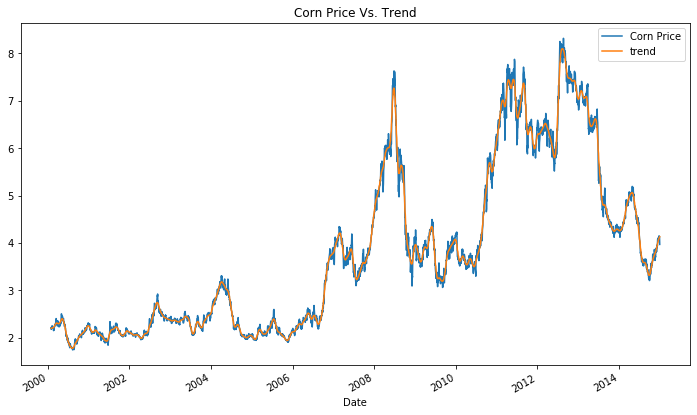

In [18]:
# Plot the Corn Price Close vs. the Trend 
corn_df_hpf["Corn_Price"].plot(label = 'Corn Price', figsize=(10,6),legend = True)
corn_df_hpf.ts_trend_corn.plot(label = 'trend', title='Corn Price Vs. Trend', figsize=(12,7),legend = True);

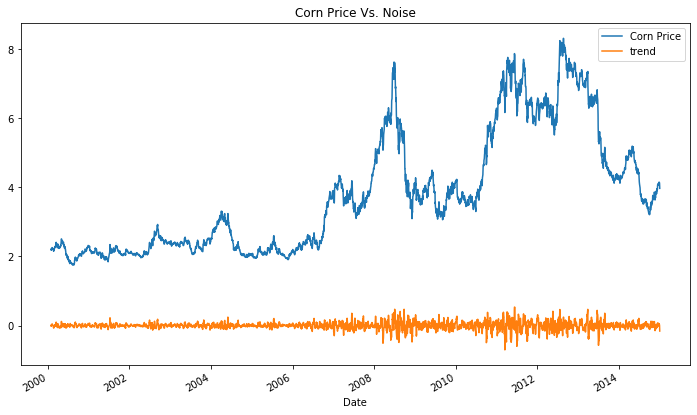

In [19]:
# Plot the Corn Price Close vs. the Trend 
corn_df_hpf["Corn_Price"].plot(label = 'Corn Price', figsize=(10,6),legend = True)
corn_df_hpf.ts_noise_corn.plot(label = 'trend', title='Corn Price Vs. Noise', figsize=(12,7),legend = True);

## Variable Selection for the ARIMA Model

Comparing Absolute Corn Price versus percent change metrics to conclude which variable is better fit for model development 

In [20]:
# Creating percent change of the Adj Close 
corn_returns = (corn_df_tr[['Corn_Price']].pct_change()).replace(-np.inf, np.nan).dropna()
corn_returns.tail()

,Corn_Price
Date,
2014-12-24,-0.015097
2014-12-26,0.017167
2014-12-29,-0.004822
2014-12-30,-0.015142
2014-12-31,-0.023370


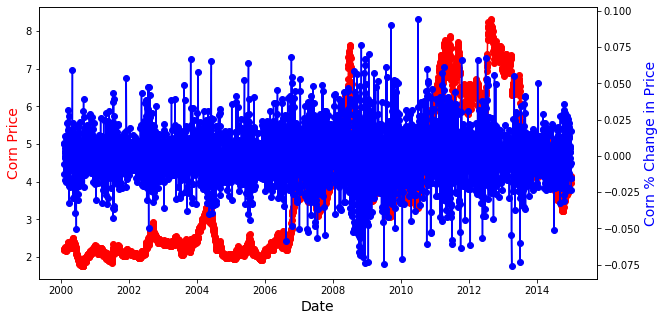

In [21]:
# Plotting the Absolute Corn price versus % change in the Corn price to determine which data should be used in
# modelling exercise

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize= (10,5))
# make a plot
ax.plot(corn_df_tr.index, corn_df_tr['Corn_Price'], color="red", marker="o")
# # set x-axis label
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Corn Price",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(corn_returns.index, corn_returns['Corn_Price'],color="blue",marker="o")
ax2.set_ylabel("Corn % Change in Price",color="blue",fontsize=14)
plt.show()

From the above graphs it is evident that % change in the corn prices is more stationary than the absolute corn price and hence, should be used in ARIMA modelling

## Autocorrelation & Partial Autocorrelation Analysis

Use the autocorrelation and partial autocorrelation data to get a sense of how many lags to use in the ARIMA models

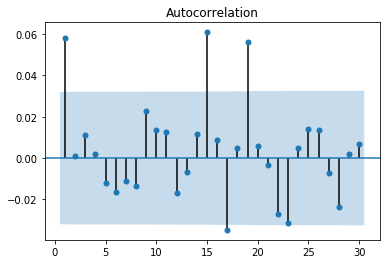

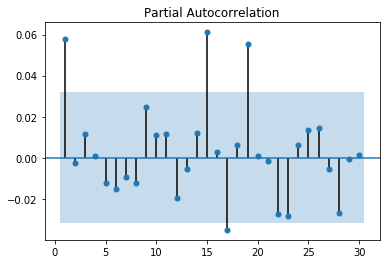

In [22]:
# Import ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(corn_returns['Corn_Price'], lags=30, zero=False)
plot_pacf(corn_returns['Corn_Price'], lags=30, zero=False);

ACF plot is a bar chart of coefficients of correlation between a time series and it lagged values. Basically, how well the present value of the series is related to its past values. While, PACF is the partial autocorrelation function that explains the partial correlation between the series and lags of itself.

Both ACF and PACF can be used to identify the orders of AR and MA terms in the ARMA model.

From the above ACF plot we notice that 3-4 lags could potentialy useful while PACF is significant at the 4-5 lags are outside the default confidence interval of 95%. Hence, we will play with p and q accordingly to create the ARIMA models for each of the pharmaceutical stocks.

## Forecasting Corn Returns using an ARIMA Model

In [23]:
# Estimate ARIMA Model:
model = ARIMA(corn_returns['Corn_Price'], order=(3, 1,2))
# Fit the model
results = model.fit()
# save model
results.save("../Model_Results/Corn_ARIMA_PC_model.pkl")

from statsmodels.tsa.arima_model import ARIMAResults
# load model
loaded = ARIMAResults.load("../Model_Results/Corn_ARIMA_PC_model.pkl")
# Output model summary results:
results.summary()

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\Anirban\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:90

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Corn_Price   No. Observations:                 3758
Model:                 ARIMA(3, 1, 2)   Log Likelihood                9763.507
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sat, 21 Nov 2020   AIC                         -19513.014
Time:                        14:30:04   BIC                         -19469.393
Sample:                             1   HQIC                        -19497.503
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.176e-07   3.88e-07     -0.303      0.762   -8.78e-07    6.43e-07
ar.L1.D.Corn_Price    -0.7147        nan        nan        nan         nan         nan
ar.L2.D.Corn_Price     0.0440      0.016      2.706      0.007       0.012       0.076
ar.L3.D.Corn_Price     0.0047      0.016      0.288      0.773      -0.027       0.036
ma.L1.D.Corn_Price    -0.2236        nan        nan        nan         nan         nan
ma.L2.D.Corn_Price    -0.7751        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3085           +0.0000j            1.3085            0.5000
AR.2            9.3632           +0.0000j            9.3632            0.0000
AR.3          -17.4537           +0.0000j           17.4537            0.5000
MA.1            1.0007           +0.0000j            1.0007            0.0000
MA.2           -1.2893           +0.0000j            1.2893            0.5000
-----------------------------------------------------------------------------
"""

In [24]:
# #Getting the forecasted values of the adjusted closing price
corn_forecasted_values=np.array(1+ results.forecast(steps=1043)[0])
for i in range(1, len(corn_forecasted_values)):
    corn_forecasted_values[i] = corn_forecasted_values[i]*corn_forecasted_values[i-1]
corn_forecasted_values = corn_forecasted_values*corn_act_prices.loc['2015-08-28']['Corn_Price']
corn_forecasted_values

NameError: name 'combined_portfolios_df' is not defined

## Validation of the Corn

In [31]:
# Getting the array of the actual adjusted closing prices for Corn stock
corn_actual_val = np.array(corn_df_val["Corn_Price"])
# Calculating the differnce between actual and forecasted values
abs_change = np.absolute(np.array(corn_actual_val) - np.array(corn_forecasted_values))
corn_avg_error = sum(abs_change)/ len(abs_change)
# Printing the average error term
print(corn_avg_error)

1.355249214281271


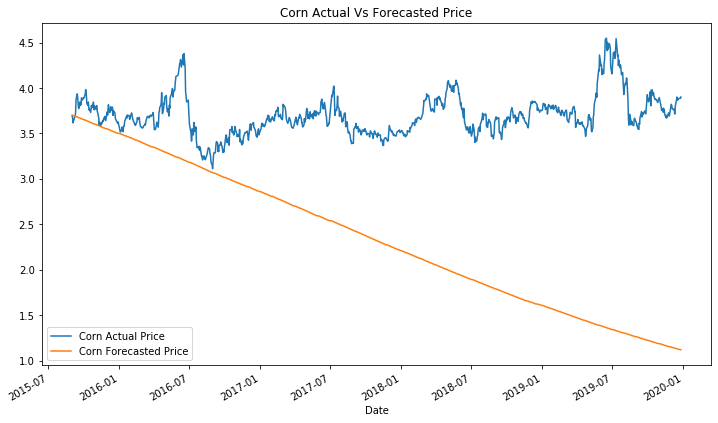

In [32]:
# Combining Date,Actual and Predicted Adj Closing price for Corn 
Corn_Comp1 = pd.DataFrame({'Date': corn_df_val.index.values, 'Corn_Actual_Price': corn_actual_val, 'Corn_Forecasted_Price': corn_forecasted_values}, columns=['Date', 'Corn_Actual_Price', 'Corn_Forecasted_Price'])
Corn_Comp= Corn_Comp1.set_index("Date")
# Plot the variation of model
Corn_Comp["Corn_Actual_Price"].plot(label = 'Corn Actual Price', figsize=(10,6),legend = True)
Corn_Comp["Corn_Forecasted_Price"].plot(label = 'Corn Forecasted Price', title='Corn Actual Vs Forecasted Price', figsize=(12,7),legend = True);
plt.savefig("../Images/TS_Corn_Actual_Forecasted.png")

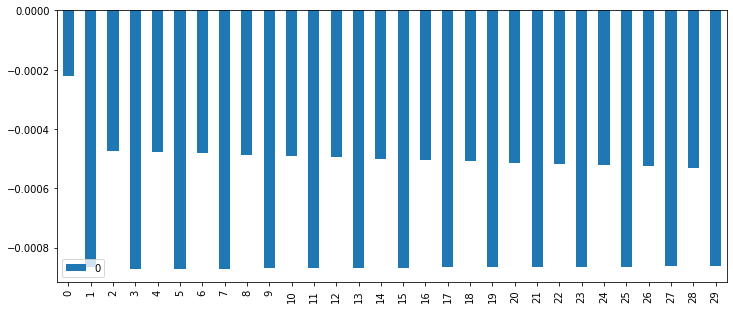

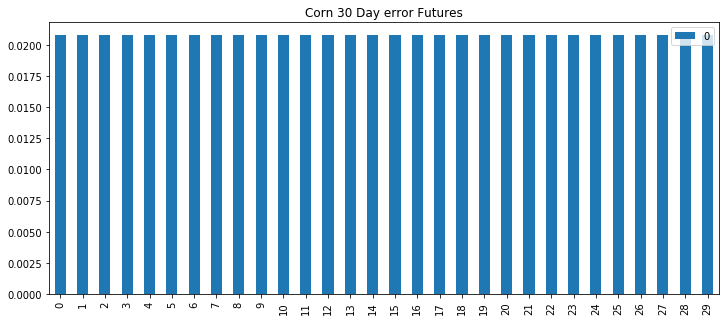

In [33]:
# Plot the 1 month of Closing Price Forecast
pd.DataFrame(results.forecast(steps=30)[0]).plot(kind='bar',figsize=(12,5),legend = True)
pd.DataFrame(results.forecast(steps=30)[1]).plot(kind='bar',title="Corn 30 Day error Futures",figsize=(12,5),legend = True);